In [23]:
import pandas as pd
import glob
import os
import re # For regular expressions to extract ticker from filename
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

def load_csv_files_from_folder(folder_path):
    """
    Loads all CSV files from a given folder into a list of DataFrames.
    Adds a 'Ticker' column to each DataFrame, inferred from the filename.
    Ensures 'Date' column is datetime index.
    """
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    loaded_dataframes = []

    if not csv_files:
        print(f"No CSV files found in '{folder_path}'.")
        return loaded_dataframes

    print(f"Attempting to load {len(csv_files)} CSV files from '{folder_path}'...")
    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)

            # --- Extract Ticker from filename and add as a column ---
            # Corrected Regex: Matches characters at the start until an underscore, then '.csv'
            # For 'MSFT_historical_data.csv', it will capture 'MSFT'.
            filename = os.path.basename(file_path)
            ticker_match = re.match(r'([A-Za-z0-9]+)_historical_data\.csv', filename)
            if ticker_match:
                ticker_symbol = ticker_match.group(1).upper()
                df['Ticker'] = ticker_symbol
            else:
                print(f"Warning: Could not extract ticker from filename '{filename}'. Skipping this file.")
                continue # Skip if ticker can't be identified

            # --- Ensure 'Date' column is datetime and set as index ---
            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
                df.dropna(subset=['Date'], inplace=True) # Remove rows where Date couldn't be parsed
                df.set_index('Date', inplace=True)
                df.sort_index(inplace=True) # Ensure chronological order
            else:
                print(f"Warning: 'Date' column not found in '{filename}'. Skipping this file.")
                continue

            loaded_dataframes.append(df)
            print(f"  Loaded {ticker_symbol} with {len(df)} rows.")

        except Exception as e:
            print(f"Error loading or processing '{file_path}': {e}. Skipping.")
            pass

    return loaded_dataframes

# --- Execution for Stock Data ---
# PLEASE ENSURE THIS PATH IS CORRECT FOR YOUR STOCK CSVs
yfinance_data_folder = '../data/yfinance_data/' 
all_yfinance_dfs = load_csv_files_from_folder(yfinance_data_folder)

print(f"\nSuccessfully loaded {len(all_yfinance_dfs)} Stock DataFrames.")
if all_yfinance_dfs:
    print("\nHead of the first loaded Stock DataFrame (should now have 'Ticker' column and DatetimeIndex):")
    print(all_yfinance_dfs[0].head())
    print(all_yfinance_dfs[0].info())


# --- Execution for News Data ---
# PLEASE ENSURE THIS PATH IS CORRECT FOR YOUR NEWS CSV
news_file_path = '../data/raw_analyst_ratings.csv/raw_analyst_ratings.csv'
try:
    df_news_original = pd.read_csv(news_file_path) # Renamed to df_news_original for clarity
    print(f"\n\nDataset loaded successfully from '{news_file_path}'. Displaying the first 5 rows and info:")
    print(df_news_original.head(5))
    print("\n")
    df_news_original.info()
except FileNotFoundError:
    print(f"Error: '{news_file_path}' not found. Please check the path.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading the news dataset: {e}")
    exit()

# From now on, we will work with 'df_news_original' for news processing

Attempting to load 7 CSV files from '../data/yfinance_data/'...
  Loaded MSFT with 9672 rows.
  Loaded NVDA with 6421 rows.
  Loaded AMZN with 6846 rows.
  Loaded TSLA with 3545 rows.
  Loaded META with 2926 rows.
  Loaded AAPL with 10998 rows.
  Loaded GOOG with 5020 rows.

Successfully loaded 7 Stock DataFrames.

Head of the first loaded Stock DataFrame (should now have 'Ticker' column and DatetimeIndex):
                Open      High       Low     Close  Adj Close      Volume  \
Date                                                                        
1986-03-13  0.088542  0.101563  0.088542  0.097222   0.059946  1031788800   
1986-03-14  0.097222  0.102431  0.097222  0.100694   0.062087   308160000   
1986-03-17  0.100694  0.103299  0.100694  0.102431   0.063158   133171200   
1986-03-18  0.102431  0.103299  0.098958  0.099826   0.061552    67766400   
1986-03-19  0.099826  0.100694  0.097222  0.098090   0.060482    47894400   

            Dividends  Stock Splits Ticker  
Date

In [13]:
import pandas as pd
# Assuming df_news_original is loaded from the previous block

print("\n--- Starting News Data Normalization and Alignment for 'df_news_original' ---")

# --- Step 1: Standardize 'date' Column to Datetime Objects ---
# Explanation: Your news 'date' column contains full timestamps with timezone offsets
# (e.g., '2020-06-05 10:30:54-04:00'). For Pandas to efficiently work with dates
# and for proper alignment, it must be converted into a standardized `datetime` format.
# `errors='coerce'` is crucial: if any date string cannot be parsed, it will be
# converted to `NaT` (Not a Time/Date) instead of raising an error.
# We then drop these `NaT` entries because they cannot be aligned.
# Note: pd.to_datetime handles timezone offsets automatically, resulting in timezone-aware datetimes.
print("\n--- Step 1: Converting 'date' column to Datetime ---")
df_news_processed = df_news_original.copy() # Work on a copy of the original news DataFrame
df_news_processed['date'] = pd.to_datetime(df_news_processed['date'], errors='coerce')
# Drop rows where date parsing failed (i.e., 'date' became NaT)
df_news_processed.dropna(subset=['date'], inplace=True)

print("News DataFrame after converting 'date' to datetime and dropping NaTs:")
print(df_news_processed.head())
print(df_news_processed.info())


# --- Step 2: Normalize Timestamps to Date Only ---
# Explanation: Stock data is typically daily (one data point per day) and does not
# include time components or timezone information (it's usually market-specific).
# Your news dates currently include exact times and timezone offsets.
# To align news perfectly with daily stock data, we need to strip both the time
# component and the timezone information, leaving only the calendar date
# (e.g., '2020-06-05 10:30:54-04:00' becomes '2020-06-05 00:00:00').
# `.dt.normalize()` handles this: it converts to timezone-naive datetime and sets time to midnight.
print("\n--- Step 2: Normalizing Timestamps to Date Only ---")
df_news_processed['aligned_date'] = df_news_processed['date'].dt.normalize()
print("News DataFrame with 'aligned_date' (date-only, timezone-naive):")
print(df_news_processed.head())
print(df_news_processed.info())


# --- Step 3: Standardize 'stock' Column ---
# Explanation: This column identifies which company the news refers to. It's crucial
# that these entries (e.g., 'A', 'MSFT') are clean and consistent. Stock ticker
# symbols are typically uppercase. We'll convert them to string type, then to
# uppercase, and strip any leading/trailing whitespace to ensure uniformity.
# We'll also drop any rows where the 'stock' symbol is missing or becomes empty,
# as we cannot link such news to a specific company.
print("\n--- Step 3: Cleaning and Standardizing 'stock' column ---")
df_news_processed['stock'] = df_news_processed['stock'].astype(str).str.upper().str.strip()
df_news_processed.dropna(subset=['stock'], inplace=True) # Drop if 'stock' is NaN/empty after cleaning

# It's a good idea to ensure only the desired big tech tickers are present if you don't
# want to process news for other stocks like 'A' (Agilent)
desired_big_tech_tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
initial_rows = len(df_news_processed)
df_news_processed = df_news_processed[df_news_processed['stock'].isin(desired_big_tech_tickers)].copy()
print(f"Filtered for desired big tech tickers. Removed {initial_rows - len(df_news_processed)} rows.")
print("News DataFrame after standardizing and filtering 'stock' column:")
print(df_news_processed.head())
print(df_news_processed.info())


# --- Step 4: Aggregate News per Day per Ticker ---
# Explanation: On any given 'aligned_date', there might be multiple news articles
# for the same stock. To align with a single daily stock price entry,
# you need to summarize these multiple news items into a single daily record.
# This aggregation consolidates all news for a specific stock on a particular day.
# Here, we'll count the number of articles and take the first headline published
# on that day for that stock. You could also include sentiment analysis here
# if you have a numerical sentiment score derived from your 'sentiment' column.
print("\n--- Step 4: Aggregating News per Day per Ticker ---")
aggregated_news_df = df_news_processed.groupby(['aligned_date', 'stock']).agg(
    news_count=('headline', 'size'), # Count the number of news articles
    first_headline=('headline', lambda x: x.iloc[0]) # Get the first headline of the day for that stock
    # If you have a 'sentiment' column and have converted it to numerical scores (e.g., -1, 0, 1),
    # you could add: 'avg_sentiment': ('sentiment_score', 'mean')
).reset_index() # reset_index moves 'aligned_date' and 'stock' back into regular columns

print("Aggregated News DataFrame (first 5 rows):")
print(aggregated_news_df.head())
print(aggregated_news_df.info())


# --- Step 5: Final Preparation: Rename 'aligned_date' to 'Date' and Set as Index ---
# Explanation: For efficient and clean merging with your stock DataFrames
# (which have their 'Date' as the index, as modified in Step 0), it's a best practice
# to also rename the aggregated date column to 'Date' and set it as the index
# of this news DataFrame. This prepares it for a direct index-to-index merge.
print("\n--- Step 5: Final Preparation: Rename 'aligned_date' to 'Date' and Set as Index ---")
aggregated_news_df.rename(columns={'aligned_date': 'Date'}, inplace=True)
aggregated_news_df.set_index('Date', inplace=True)

print("Final Aggregated News DataFrame ready for merging (first 5 rows):")
print(aggregated_news_df.head())
print(aggregated_news_df.info())

print("\n--- News Data Normalization and Alignment Complete ---")
print("The 'aggregated_news_df' is now prepared and ready to be merged with your historical stock data (all_yfinance_dfs).")


--- Starting News Data Normalization and Alignment for 'df_news_original' ---

--- Step 1: Converting 'date' column to Datetime ---
News DataFrame after converting 'date' to datetime and dropping NaTs:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://ww

In [11]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /home/ca/nltk_data...


True

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# --- Ensure VADER lexicon is downloaded ---
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    print("VADER lexicon not found. Downloading...")
    nltk.download('vader_lexicon')
    print("VADER lexicon downloaded.")

print("\n--- Starting Sentiment Analysis on News Headlines ---")

# --- Initialize the VADER sentiment analyzer ---
analyzer = SentimentIntensityAnalyzer()

# --- Re-create df_news_processed to ensure it's in the correct state ---

# Load the original news data again (assuming it's available from previous blocks)
news_file_path = '../data/raw_analyst_ratings.csv/raw_analyst_ratings.csv'
try:
    df_news_original = pd.read_csv(news_file_path)
except FileNotFoundError:
    print(f"Error: '{news_file_path}' not found. Cannot perform sentiment analysis.")
    exit()
except Exception as e:
    print(f"An error occurred loading news data for sentiment analysis: {e}")
    exit()

df_news_processed = df_news_original.copy()

# Step 1: Standardize 'date' column to Datetime Objects
df_news_processed['date'] = pd.to_datetime(df_news_processed['date'], errors='coerce')
df_news_processed.dropna(subset=['date'], inplace=True)

# Step 2: Normalize Timestamps to Date Only
df_news_processed['aligned_date'] = df_news_processed['date'].dt.normalize()

# Step 3: Standardize 'stock' Column
df_news_processed['stock'] = df_news_processed['stock'].astype(str).str.upper().str.strip()
df_news_processed.dropna(subset=['stock'], inplace=True)
desired_big_tech_tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
df_news_processed = df_news_processed[df_news_processed['stock'].isin(desired_big_tech_tickers)].copy()
# Ensure 'headline' column is string type and handle potential NaNs before sentiment analysis
df_news_processed['headline'] = df_news_processed['headline'].astype(str).fillna('')

print("\nDataFrame state before sentiment analysis (first 5 rows with relevant columns):")
print(df_news_processed[['date', 'aligned_date', 'stock', 'headline']].head())
print(df_news_processed.info())

# --- Step 1: Calculate Sentiment Scores for Each Headline ---
# Explanation: We define a function that takes a text (headline) and uses VADER
# to return a 'compound' sentiment score. The compound score is a normalized
# weighted composite score, typically ranging from -1 (most negative) to +1 (most positive).
# A score closer to 0 indicates neutrality.
print("\n--- Step 1: Calculating VADER Compound Sentiment Scores ---")

def get_vader_sentiment_score(text):
    if not isinstance(text, str) or not text:
        return 0.0 # Return 0 for empty or non-string headlines
    return analyzer.polarity_scores(text)['compound']

# Apply the function to the 'headline' column to create a new 'sentiment_score' column
df_news_processed['sentiment_score'] = df_news_processed['headline'].apply(get_vader_sentiment_score)

print("News DataFrame with 'sentiment_score' (first 5 rows):")
print(df_news_processed[['headline', 'sentiment_score']].head())


# --- Step 2: Categorize Sentiment (Optional but helpful for interpretation) ---
# Explanation: While a numerical score is good for quantitative analysis,
# it's often useful to categorize sentiment into labels like 'positive', 'negative',
# and 'neutral' for easier understanding and visualization.
# We'll use common thresholds:
#   - score >= 0.05: Positive
#   - score <= -0.05: Negative
#   - otherwise: Neutral (scores between -0.05 and 0.05)
print("\n--- Step 2: Categorizing Sentiment Labels ---")

def get_sentiment_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the categorization function to create a new 'sentiment_label' column
df_news_processed['sentiment_label'] = df_news_processed['sentiment_score'].apply(get_sentiment_label)

print("News DataFrame with 'sentiment_label' (first 5 rows):")
print(df_news_processed[['headline', 'sentiment_score', 'sentiment_label']].head())

print("\nSummary of sentiment labels:")
print(df_news_processed['sentiment_label'].value_counts())

print("\nSentiment analysis complete for individual news headlines.")
print("The 'df_news_processed' DataFrame now contains 'sentiment_score' and 'sentiment_label' columns.")



--- Starting Sentiment Analysis on News Headlines ---

DataFrame state before sentiment analysis (first 5 rows with relevant columns):
                          date              aligned_date stock  \
6680 2020-06-10 11:33:26-04:00 2020-06-10 00:00:00-04:00  AAPL   
6681 2020-06-10 08:14:08-04:00 2020-06-10 00:00:00-04:00  AAPL   
6682 2020-06-10 07:53:47-04:00 2020-06-10 00:00:00-04:00  AAPL   
6683 2020-06-10 07:19:25-04:00 2020-06-10 00:00:00-04:00  AAPL   
6684 2020-06-10 06:27:11-04:00 2020-06-10 00:00:00-04:00  AAPL   

                                               headline  
6680  Tech Stocks And FAANGS Strong Again To Start D...  
6681      10 Biggest Price Target Changes For Wednesday  
6682  Benzinga Pro's Top 5 Stocks To Watch For Wed.,...  
6683  Deutsche Bank Maintains Buy on Apple, Raises P...  
6684  Apple To Let Users Trade In Their Mac Computer...  
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 6680 to 1255230
Data columns (total 7 columns):
 #   Column   

In [15]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re # For regular expressions (used in stock data loading if needed)
import os # For file path operations
import glob # For listing files

# --- 0. Ensure NLTK VADER lexicon is downloaded ---
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    print("VADER lexicon not found. Downloading...")
    nltk.download('vader_lexicon')
    print("VADER lexicon downloaded.")

print("--- Starting Full News Data Processing with Sentiment Analysis ---")

# --- 1. Load the News Data (as per your specified path) ---
news_file_path = '../data/raw_analyst_ratings.csv/raw_analyst_ratings.csv'
try:
    df_news_original = pd.read_csv(news_file_path)
    print(f"\nNews dataset loaded successfully from '{news_file_path}'.")
except FileNotFoundError:
    print(f"Error: News file '{news_file_path}' not found. Please check the path.")
    exit()
except Exception as e:
    print(f"An error occurred loading news data: {e}")
    exit()

print("Original News DataFrame head:")
print(df_news_original.head())
print("\nOriginal News DataFrame info:")
df_news_original.info()


# --- 2. Initial News Data Processing (Steps from previous alignment) ---
# Create a working copy
df_news_processed = df_news_original.copy()

# Step 2.1: Standardize 'date' column to Datetime Objects
df_news_processed['date'] = pd.to_datetime(df_news_processed['date'], errors='coerce')
df_news_processed.dropna(subset=['date'], inplace=True)
print("\nAfter date conversion and NaT drop:")
print(df_news_processed.info())

# Step 2.2: Normalize Timestamps to Date Only
df_news_processed['aligned_date'] = df_news_processed['date'].dt.normalize()
print("\nAfter date normalization:")
print(df_news_processed.info())

# Step 2.3: Standardize 'stock' Column and filter for big tech
df_news_processed['stock'] = df_news_processed['stock'].astype(str).str.upper().str.strip()
df_news_processed.dropna(subset=['stock'], inplace=True)
desired_big_tech_tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA'] # Ensure these match your stock files
initial_rows = len(df_news_processed)
df_news_processed = df_news_processed[df_news_processed['stock'].isin(desired_big_tech_tickers)].copy()
print(f"\nAfter stock standardization and filtering for {len(desired_big_tech_tickers)} big tech tickers. Removed {initial_rows - len(df_news_processed)} rows.")
print(df_news_processed.info())

# Ensure 'headline' column is string type and handle potential NaNs before sentiment analysis
df_news_processed['headline'] = df_news_processed['headline'].astype(str).fillna('')


# --- 3. Sentiment Analysis on Headlines ---
print("\n--- Performing Sentiment Analysis on Headlines ---")
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment_score(text):
    if not isinstance(text, str) or not text:
        return 0.0 # Return 0 for empty or non-string headlines
    return analyzer.polarity_scores(text)['compound']

df_news_processed['sentiment_score'] = df_news_processed['headline'].apply(get_vader_sentiment_score)

print("News DataFrame with 'sentiment_score' (first 5 rows with headline and score):")
print(df_news_processed[['headline', 'sentiment_score']].head())
print(f"Sentiment analysis complete. Added 'sentiment_score' column. Total rows: {len(df_news_processed)}")


# --- 4. Re-aggregate News per Day per Ticker (INCLUDING SENTIMENT) ---
print("\n--- Re-aggregating News Data, including Mean Sentiment Score ---")
aggregated_news_df = df_news_processed.groupby(['aligned_date', 'stock']).agg(
    news_count=('headline', 'size'), # Count number of headlines
    first_headline=('headline', lambda x: x.iloc[0]), # Get the first headline
    avg_sentiment=('sentiment_score', 'mean') # Calculate the mean sentiment for the day/stock
).reset_index() # Moves 'aligned_date' and 'stock' back to columns

print("Aggregated News DataFrame (first 5 rows, including avg_sentiment):")
print(aggregated_news_df.head())
print(f"Aggregated DataFrame shape: {aggregated_news_df.shape}")


# --- 5. Final Preparation: Rename 'aligned_date' to 'Date' and Set as Index ---
print("\n--- Final Preparation: Renaming 'aligned_date' to 'Date' and Setting as Index ---")
aggregated_news_df.rename(columns={'aligned_date': 'Date'}, inplace=True)
aggregated_news_df.set_index('Date', inplace=True)

print("Final 'aggregated_news_df' ready for merging with stock data:")
print(aggregated_news_df.head(10)) # Display more rows to see some variety
print("\nFinal 'aggregated_news_df' info:")
print(aggregated_news_df.info())

print("\n--- News Data Processing with Sentiment Analysis Complete ---")
print("You can now see the 'news_count' and 'avg_sentiment' for each stock on each trading day.")

--- Starting Full News Data Processing with Sentiment Analysis ---

News dataset loaded successfully from '../data/raw_analyst_ratings.csv/raw_analyst_ratings.csv'.
Original News DataFrame head:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzin

In [18]:
import pandas as pd
import glob
import os
import re # For regular expressions to extract ticker from filename

# --- Data Loading Function (from your previous prompts, slightly refined) ---
def load_csv_files_from_folder(folder_path):
    """
    Loads all CSV files from a given folder into a list of DataFrames.
    Adds a 'Ticker' column to each DataFrame, inferred from the filename.
    Ensures 'Date' column is datetime index.
    """
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    loaded_dataframes = []

    if not csv_files:
        print(f"No CSV files found in '{folder_path}'.")
        return loaded_dataframes

    print(f"Attempting to load {len(csv_files)} CSV files from '{folder_path}'...")
    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)

            # --- Extract Ticker from filename and add as a column ---
            filename = os.path.basename(file_path)
            ticker_match = re.match(r'([A-Za-z0-9]+)_historical_data\.csv', filename)
            if ticker_match:
                ticker_symbol = ticker_match.group(1).upper()
                df['Ticker'] = ticker_symbol
            else:
                print(f"Warning: Could not extract ticker from filename '{filename}'. Skipping this file.")
                continue

            # --- Ensure 'Date' column is datetime and set as index ---
            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
                df.dropna(subset=['Date'], inplace=True) # Remove rows where Date couldn't be parsed
                df.set_index('Date', inplace=True)
                df.sort_index(inplace=True) # Ensure chronological order
            else:
                print(f"Warning: 'Date' column not found in '{filename}'. Skipping this file.")
                continue

            loaded_dataframes.append(df)
            print(f"  Loaded {ticker_symbol} with {len(df)} rows.")

        except Exception as e:
            print(f"Error loading or processing '{file_path}': {e}. Skipping.")
            pass

    return loaded_dataframes

# --- Execution for Stock Data ---
# PLEASE ENSURE THIS PATH IS CORRECT FOR YOUR STOCK CSVs
yfinance_data_folder = '../data/yfinance_data/'
all_yfinance_dfs = load_csv_files_from_folder(yfinance_data_folder)

print(f"\nSuccessfully loaded {len(all_yfinance_dfs)} Stock DataFrames.")
if all_yfinance_dfs:
    print("\nHead of the first loaded Stock DataFrame (before return calculation):")
    print(all_yfinance_dfs[0].head())
    print(all_yfinance_dfs[0].info())


# --- Calculate Daily Stock Returns ---
print("\n--- Calculating Daily Stock Returns for each company ---")

processed_stock_dfs = [] # To store DataFrames with calculated returns

for i, stock_df in enumerate(all_yfinance_dfs):
    ticker = stock_df['Ticker'].iloc[0] # Get the ticker from the DataFrame

    # Ensure 'Close' or 'Adj Close' column exists for calculation
    # 'Adj Close' is generally preferred as it accounts for splits and dividends
    if 'Adj Close' in stock_df.columns:
        # Compute the percentage change in daily Adjusted Closing prices
        # df.pct_change() calculates (current_value - previous_value) / previous_value
        stock_df['Daily_Return'] = stock_df['Adj Close'].pct_change() * 100 # Multiply by 100 for percentage
        print(f"  Calculated Daily_Return for {ticker} using 'Adj Close'.")
    elif 'Close' in stock_df.columns:
        # If 'Adj Close' is not available, fall back to 'Close' price
        stock_df['Daily_Return'] = stock_df['Close'].pct_change() * 100 # Multiply by 100 for percentage
        print(f"  Calculated Daily_Return for {ticker} using 'Close'.")
    else:
        print(f"  Warning: No 'Adj Close' or 'Close' column found for {ticker}. Cannot calculate Daily_Return for this stock.")
        # If returns cannot be calculated, the 'Daily_Return' column won't exist for this df
        processed_stock_dfs.append(stock_df) # Still append, but it won't have the new column
        continue # Skip to the next DataFrame

    # The first value of 'Daily_Return' will be NaN because there's no previous day.
    # This is normal and will be handled during later analysis (e.g., dropping NaNs).

    processed_stock_dfs.append(stock_df)


# Update the main list of DataFrames to include the processed ones
all_yfinance_dfs = processed_stock_dfs

print("\n--- Daily Stock Returns Calculation Complete ---")
print("Here's the head of the first stock DataFrame, now with 'Daily_Return':")
if all_yfinance_dfs:
    print(all_yfinance_dfs[0].head())
    print("\nInfo of the first stock DataFrame:")
    print(all_yfinance_dfs[0].info())
else:
    print("No stock DataFrames were processed.")

print("\nEach stock DataFrame in 'all_yfinance_dfs' now includes a 'Daily_Return' column.")

Attempting to load 7 CSV files from '../data/yfinance_data/'...
  Loaded MSFT with 9672 rows.
  Loaded NVDA with 6421 rows.
  Loaded AMZN with 6846 rows.
  Loaded TSLA with 3545 rows.
  Loaded META with 2926 rows.
  Loaded AAPL with 10998 rows.
  Loaded GOOG with 5020 rows.

Successfully loaded 7 Stock DataFrames.

Head of the first loaded Stock DataFrame (before return calculation):
                Open      High       Low     Close  Adj Close      Volume  \
Date                                                                        
1986-03-13  0.088542  0.101563  0.088542  0.097222   0.059946  1031788800   
1986-03-14  0.097222  0.102431  0.097222  0.100694   0.062087   308160000   
1986-03-17  0.100694  0.103299  0.100694  0.102431   0.063158   133171200   
1986-03-18  0.102431  0.103299  0.098958  0.099826   0.061552    67766400   
1986-03-19  0.099826  0.100694  0.097222  0.098090   0.060482    47894400   

            Dividends  Stock Splits Ticker  
Date                        

Attempting to load 7 CSV files from '../data/yfinance_data/'...
  Loaded MSFT with 9672 rows.
  Loaded NVDA with 6421 rows.
  Loaded AMZN with 6846 rows.
  Loaded TSLA with 3545 rows.
  Loaded META with 2926 rows.
  Loaded AAPL with 10998 rows.
  Loaded GOOG with 5020 rows.

Successfully loaded 7 Stock DataFrames.

--- Calculating Daily Stock Returns for each company ---

--- Daily Stock Returns Calculation Complete ---
Head of a sample DataFrame with Daily_Return:
               Close  Daily_Return
Date                              
1986-03-14  0.100694      3.571288
1986-03-17  0.102431      1.724993
1986-03-18  0.099826     -2.543215
1986-03-19  0.098090     -1.739019
1986-03-20  0.095486     -2.654676

--- Consolidating Daily Returns for Visualization ---
Consolidated returns data preview:
            Date Ticker  Daily_Return
29405 1980-12-15   AAPL     -5.217059
29406 1980-12-16   AAPL     -7.339761
29407 1980-12-17   AAPL      2.475074
29408 1980-12-18   AAPL      2.899199
29409

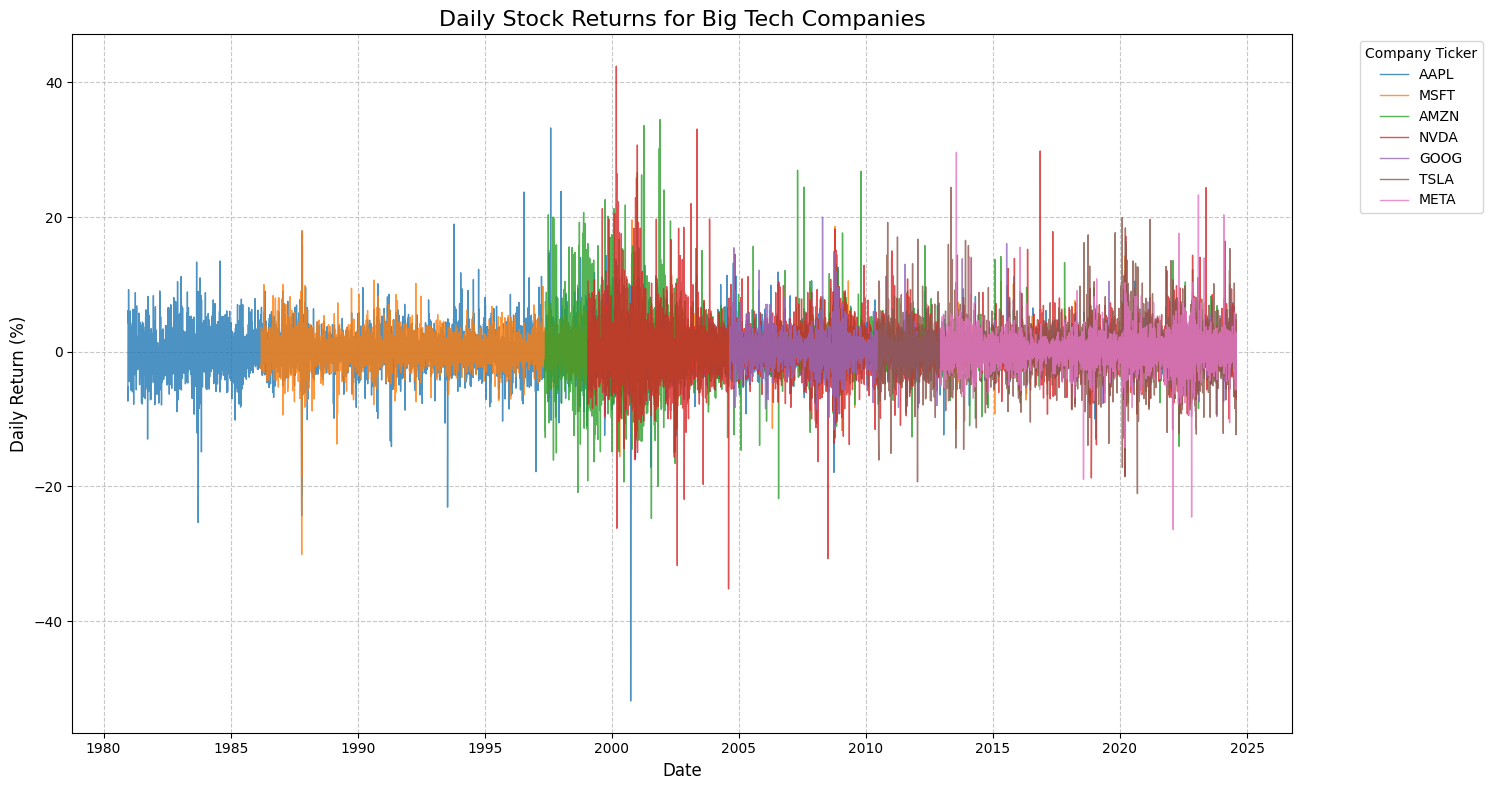


--- Graph Generation Complete ---
The plot displays the daily percentage change in closing prices for each company over time.
Positive returns mean the stock gained value on that day, negative means it lost value.
The volatility (magnitude of swings) can be observed for each stock.


In [19]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading Function (from your previous prompts) ---
def load_csv_files_from_folder(folder_path):
    """
    Loads all CSV files from a given folder into a list of DataFrames.
    Adds a 'Ticker' column to each DataFrame, inferred from the filename.
    Ensures 'Date' column is datetime index.
    """
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    loaded_dataframes = []

    if not csv_files:
        print(f"No CSV files found in '{folder_path}'.")
        return loaded_dataframes

    print(f"Attempting to load {len(csv_files)} CSV files from '{folder_path}'...")
    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            filename = os.path.basename(file_path)
            ticker_match = re.match(r'([A-Za-z0-9]+)_historical_data\.csv', filename)
            if ticker_match:
                ticker_symbol = ticker_match.group(1).upper()
                df['Ticker'] = ticker_symbol
            else:
                print(f"Warning: Could not extract ticker from filename '{filename}'. Skipping this file.")
                continue

            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
                df.dropna(subset=['Date'], inplace=True)
                df.set_index('Date', inplace=True)
                df.sort_index(inplace=True)
            else:
                print(f"Warning: 'Date' column not found in '{filename}'. Skipping this file.")
                continue

            loaded_dataframes.append(df)
            print(f"  Loaded {ticker_symbol} with {len(df)} rows.")

        except Exception as e:
            print(f"Error loading or processing '{file_path}': {e}. Skipping.")
            pass

    return loaded_dataframes

# --- Execution for Stock Data ---
yfinance_data_folder = '../data/yfinance_data/' # MAKE SURE THIS PATH IS CORRECT!
all_yfinance_dfs = load_csv_files_from_folder(yfinance_data_folder)

print(f"\nSuccessfully loaded {len(all_yfinance_dfs)} Stock DataFrames.")

# --- Calculate Daily Stock Returns for each company ---
print("\n--- Calculating Daily Stock Returns for each company ---")

processed_stock_dfs = []
for stock_df in all_yfinance_dfs:
    ticker = stock_df['Ticker'].iloc[0]
    if 'Adj Close' in stock_df.columns:
        stock_df['Daily_Return'] = stock_df['Adj Close'].pct_change() * 100
    elif 'Close' in stock_df.columns:
        stock_df['Daily_Return'] = stock_df['Close'].pct_change() * 100
    else:
        print(f"  Warning: No 'Adj Close' or 'Close' column found for {ticker}. Cannot calculate Daily_Return for this stock.")
        continue # Skip to next df if returns can't be calculated

    stock_df.dropna(subset=['Daily_Return'], inplace=True) # Drop the first NaN created by pct_change()
    processed_stock_dfs.append(stock_df)

all_yfinance_dfs = processed_stock_dfs # Update the list with processed dataframes

print("\n--- Daily Stock Returns Calculation Complete ---")
if all_yfinance_dfs:
    print("Head of a sample DataFrame with Daily_Return:")
    print(all_yfinance_dfs[0][['Close', 'Daily_Return']].head())
else:
    print("No stock dataframes available for visualization.")


# --- Prepare Data for Visualization ---
# Consolidate all daily returns into a single DataFrame for easier plotting
print("\n--- Consolidating Daily Returns for Visualization ---")
all_returns_df = pd.DataFrame()
for df in all_yfinance_dfs:
    # Ensure 'Date' is a column for merging/plotting
    df_reset = df.reset_index()
    all_returns_df = pd.concat([all_returns_df, df_reset[['Date', 'Ticker', 'Daily_Return']]], ignore_index=True)

# Sort by Date for proper time series plotting
all_returns_df.sort_values(by='Date', inplace=True)

print("Consolidated returns data preview:")
print(all_returns_df.head())
print(f"Total data points for plotting: {len(all_returns_df)}")

# --- Generate the Graph ---
print("\n--- Generating Graph for Daily Stock Returns ---")

plt.figure(figsize=(15, 8)) # Adjust figure size for better readability
sns.lineplot(
    data=all_returns_df,
    x='Date',
    y='Daily_Return',
    hue='Ticker', # Different color for each company's line
    linewidth=1.0,
    alpha=0.8 # Slightly transparent lines
)

plt.title('Daily Stock Returns for Big Tech Companies', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Return (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7) # Add a grid for easier reading
plt.legend(title='Company Ticker', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside to avoid overlap
plt.tight_layout() # Adjust layout to prevent labels/legend from cutting off
plt.show()

print("\n--- Graph Generation Complete ---")
print("The plot displays the daily percentage change in closing prices for each company over time.")
print("Positive returns mean the stock gained value on that day, negative means it lost value.")
print("The volatility (magnitude of swings) can be observed for each stock.")

Attempting to load 7 CSV files from '../data/yfinance_data/'...
  Loaded MSFT with 9672 rows.
  Loaded NVDA with 6421 rows.
  Loaded AMZN with 6846 rows.
  Loaded TSLA with 3545 rows.
  Loaded META with 2926 rows.
  Loaded AAPL with 10998 rows.
  Loaded GOOG with 5020 rows.

Successfully loaded 7 Stock DataFrames.
News dataset loaded successfully from '../data/raw_analyst_ratings.csv/raw_analyst_ratings.csv'.

--- Processing News Data and Calculating Sentiment Scores ---
Sentiment scores calculated for individual news headlines.

--- Aggregating News Data (including Average Sentiment) ---
Aggregated News Date Dtype: datetime64[ns]
News data aggregated by Date and Stock with average sentiment.

--- Calculating Daily Stock Returns and Consolidating All Stock Data ---
Combined Stock Date Dtype: datetime64[ns]
Daily Stock Returns calculated and all stock data consolidated.

--- Merging Stock Data with Aggregated News Sentiment ---
Merged data preview (Daily Returns & Avg Sentiment):
      

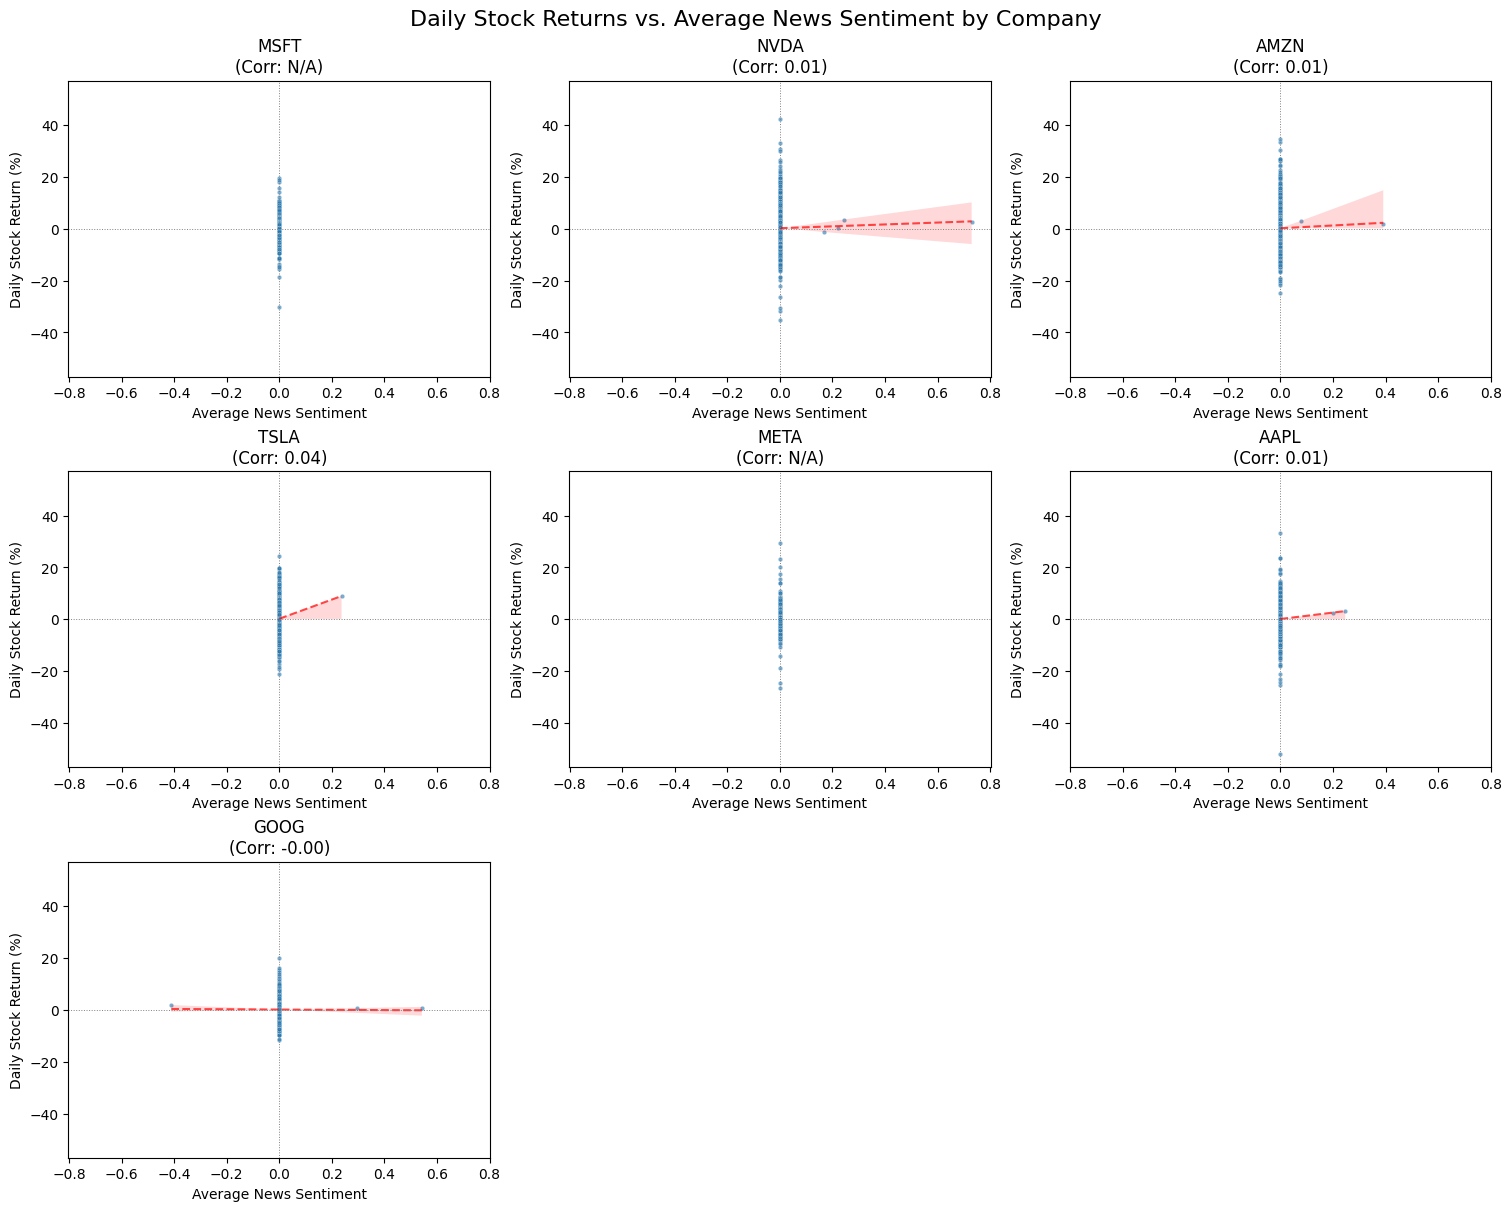


--- Analysis and Visualization Complete ---
The table above shows the Pearson correlation coefficient for each company.
The graph provides a visual representation:
- Each dot represents a specific day's average news sentiment and the corresponding daily stock return.
- The red dashed line is a linear regression line, showing the general trend.
- The correlation coefficient in each subplot's title quantifies the strength and direction of the linear relationship for that company.


In [24]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Loading Function ---
def load_csv_files_from_folder(folder_path):
    """
    Loads all CSV files from a given folder into a list of DataFrames.
    Adds a 'Ticker' column to each DataFrame, inferred from the filename.
    Ensures 'Date' column is datetime index.
    """
    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    loaded_dataframes = []

    if not csv_files:
        print(f"No CSV files found in '{folder_path}'.")
        return loaded_dataframes

    print(f"Attempting to load {len(csv_files)} CSV files from '{folder_path}'...")
    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            filename = os.path.basename(file_path)
            ticker_match = re.match(r'([A-Za-z0-9]+)_historical_data\.csv', filename)
            if ticker_match:
                ticker_symbol = ticker_match.group(1).upper()
                df['Ticker'] = ticker_symbol
            else:
                continue
            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
                df.dropna(subset=['Date'], inplace=True)
                df.set_index('Date', inplace=True)
                df.sort_index(inplace=True)
            else:
                continue
            loaded_dataframes.append(df)
            print(f"  Loaded {ticker_symbol} with {len(df)} rows.")
        except Exception as e:
            print(f"Error loading or processing '{file_path}': {e}. Skipping.")
            pass
    return loaded_dataframes

# --- Load Stock Data ---
yfinance_data_folder = '../data/yfinance_data/'
all_yfinance_dfs = load_csv_files_from_folder(yfinance_data_folder)
print(f"\nSuccessfully loaded {len(all_yfinance_dfs)} Stock DataFrames.")

# --- Load News Data ---
news_file_path = '../data/raw_analyst_ratings.csv/raw_analyst_ratings.csv'
try:
    df_news_original = pd.read_csv(news_file_path)
    print(f"News dataset loaded successfully from '{news_file_path}'.")
except Exception as e:
    print(f"Error loading news data: {e}. Exiting.")
    exit()

# --- News Data Processing and Sentiment Analysis ---
print("\n--- Processing News Data and Calculating Sentiment Scores ---")
df_news_processed = df_news_original.copy()
df_news_processed['date'] = pd.to_datetime(df_news_processed['date'], errors='coerce')
df_news_processed.dropna(subset=['date'], inplace=True)
df_news_processed['aligned_date'] = df_news_processed['date'].dt.normalize()
df_news_processed['stock'] = df_news_processed['stock'].astype(str).str.upper().str.strip()
df_news_processed.dropna(subset=['stock'], inplace=True)
desired_big_tech_tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
df_news_processed = df_news_processed[df_news_processed['stock'].isin(desired_big_tech_tickers)].copy()
df_news_processed['headline'] = df_news_processed['headline'].astype(str).fillna('')

try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except nltk.downloader.DownloadError:
    print("VADER lexicon not found. Downloading...")
    nltk.download('vader_lexicon')
    print("VADER lexicon downloaded.")

analyzer = SentimentIntensityAnalyzer()
def get_vader_sentiment_score(text):
    if not isinstance(text, str) or not text: return 0.0
    return analyzer.polarity_scores(text)['compound']
df_news_processed['sentiment_score'] = df_news_processed['headline'].apply(get_vader_sentiment_score)
print("Sentiment scores calculated for individual news headlines.")

# --- Aggregate News Data (including sentiment) ---
print("\n--- Aggregating News Data (including Average Sentiment) ---")
aggregated_news_df = df_news_processed.groupby(['aligned_date', 'stock']).agg(
    news_count=('headline', 'size'),
    first_headline=('headline', lambda x: x.iloc[0]),
    avg_sentiment=('sentiment_score', 'mean')
).reset_index()
aggregated_news_df.rename(columns={'aligned_date': 'Date'}, inplace=True)

# --- FIX: Ensure 'Date' column is timezone-naive for merging ---
if pd.api.types.is_datetime64tz_dtype(aggregated_news_df['Date']):
    aggregated_news_df['Date'] = aggregated_news_df['Date'].dt.tz_localize(None)
print(f"Aggregated News Date Dtype: {aggregated_news_df['Date'].dtype}")
print("News data aggregated by Date and Stock with average sentiment.")


# --- Calculate Daily Stock Returns and Consolidate Stock Data ---
print("\n--- Calculating Daily Stock Returns and Consolidating All Stock Data ---")
combined_stock_df = pd.DataFrame()
for stock_df in all_yfinance_dfs:
    if 'Close' in stock_df.columns:
        stock_df['Daily_Return'] = stock_df['Close'].pct_change() * 100
    elif 'Adj Close' in stock_df.columns:
        stock_df['Daily_Return'] = stock_df['Adj Close'].pct_change() * 100
    else:
        print(f"Warning: No 'Close' or 'Adj Close' column found for {stock_df['Ticker'].iloc[0]}. Cannot calculate Daily_Return.")
        continue
    stock_df.dropna(subset=['Daily_Return'], inplace=True)
    stock_df_reset = stock_df.reset_index()
    combined_stock_df = pd.concat([combined_stock_df, stock_df_reset], ignore_index=True)

combined_stock_df['Date'] = pd.to_datetime(combined_stock_df['Date'], errors='coerce')
combined_stock_df.dropna(subset=['Date'], inplace=True)

# --- FIX: Ensure 'Date' column is timezone-naive for merging ---
if pd.api.types.is_datetime64tz_dtype(combined_stock_df['Date']):
    combined_stock_df['Date'] = combined_stock_df['Date'].dt.tz_localize(None)
print(f"Combined Stock Date Dtype: {combined_stock_df['Date'].dtype}")
print("Daily Stock Returns calculated and all stock data consolidated.")


# --- Merge Stock Data and Aggregated News Sentiment ---
print("\n--- Merging Stock Data with Aggregated News Sentiment ---")
merged_data = pd.merge(
    combined_stock_df,
    aggregated_news_df,
    left_on=['Date', 'Ticker'],
    right_on=['Date', 'stock'],
    how='left'
)
merged_data.drop(columns=['stock'], inplace=True)
merged_data['news_count'].fillna(0, inplace=True)
merged_data['avg_sentiment'].fillna(0, inplace=True)

print("Merged data preview (Daily Returns & Avg Sentiment):")
print(merged_data[['Date', 'Ticker', 'Daily_Return', 'avg_sentiment', 'news_count']].head())
print(f"Total merged data rows: {len(merged_data)}")

# --- Correlation Analysis ---
print("\n--- Performing Correlation Analysis ---")

correlation_data = merged_data.dropna(subset=['Daily_Return', 'avg_sentiment']).copy()

correlation_results = {}
for ticker in desired_big_tech_tickers:
    ticker_df = correlation_data[correlation_data['Ticker'] == ticker]
    if not ticker_df.empty:
        correlation = ticker_df['Daily_Return'].corr(ticker_df['avg_sentiment'])
        correlation_results[ticker] = correlation
    else:
        correlation_results[ticker] = np.nan

correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Correlation_Coefficient'])
correlation_df.index.name = 'Ticker'

print("\n--- Correlation Results (Daily Stock Returns vs. Average News Sentiment) ---")
print(correlation_df)

# --- Generate the Graph ---
print("\n--- Generating Visual Representation: Daily Stock Returns vs. Average News Sentiment ---")

plot_data = merged_data.dropna(subset=['Daily_Return', 'avg_sentiment', 'Ticker']).copy()

unique_tickers = plot_data['Ticker'].unique()
num_companies = len(unique_tickers)
n_cols = 3
n_rows = (num_companies + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), constrained_layout=True)
axes = axes.flatten()

all_returns = plot_data['Daily_Return']
all_sentiments = plot_data['avg_sentiment']

sentiment_limit = max(abs(all_sentiments.min()), abs(all_sentiments.max())) * 1.1
sentiment_axis_lims = [-sentiment_limit, sentiment_limit]

return_limit = max(abs(all_returns.min()), abs(all_returns.max())) * 1.1
return_axis_lims = [-return_limit, return_limit]

for i, ticker in enumerate(unique_tickers):
    if i >= len(axes):
        break
    ax = axes[i]
    ticker_df = plot_data[plot_data['Ticker'] == ticker]

    corr_value = correlation_results.get(ticker, np.nan)
    corr_text = f"Corr: {corr_value:.2f}" if pd.notna(corr_value) else "Corr: N/A"

    sns.scatterplot(
        x='avg_sentiment',
        y='Daily_Return',
        data=ticker_df,
        ax=ax,
        alpha=0.6,
        s=10
    )

    sns.regplot(
        x='avg_sentiment',
        y='Daily_Return',
        data=ticker_df,
        ax=ax,
        scatter=False,
        color='red',
        line_kws={'linestyle': '--', 'linewidth': 1.5, 'alpha': 0.7}
    )

    ax.set_title(f'{ticker}\n({corr_text})')
    ax.set_xlabel('Average News Sentiment')
    ax.set_ylabel('Daily Stock Return (%)')

    ax.set_xlim(sentiment_axis_lims)
    ax.set_ylim(return_axis_lims)

    ax.axhline(0, color='gray', linestyle=':', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle=':', linewidth=0.7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Daily Stock Returns vs. Average News Sentiment by Company', fontsize=16)
plt.show()

print("\n--- Analysis and Visualization Complete ---")
print("The table above shows the Pearson correlation coefficient for each company.")
print("The graph provides a visual representation:")
print("- Each dot represents a specific day's average news sentiment and the corresponding daily stock return.")
print("- The red dashed line is a linear regression line, showing the general trend.")
print("- The correlation coefficient in each subplot's title quantifies the strength and direction of the linear relationship for that company.")